**Yong Zhu Cheng A0275768H**

The objective of the project is to train a machine to generate an empathetic response to a given prompt, leveraging the large EmpatheticDialogues dataset developed by Rashkin et al.(2018). The dataset consists of crowd-sourced one-on-one dialogues covering a range of emotions, with human-annotated emotions as a key feature.

The model used is a pre-trained version of BART, an encoder-decoder architecture that was pre-trained on the principle of denoising documents. This approach is different from the one proposed in my HW2 submission, as an extremely large amount of data and time would have been needed to train a transformer from scratch. On other hand, the pretrained model readily lends itself to interesting sequence-to-sequence applications, which makes it a more feasible subject of experimentation and study in this short span of time.

## 1. Init

In [1]:
import pandas as pd
import numpy as np
import math
import os
import tarfile
from tqdm.auto import tqdm
import torch
from transformers import BertTokenizer, BertGenerationEncoder, BertGenerationDecoder, EncoderDecoderModel
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import Seq2SeqTrainingArguments, Trainer
from datasets import Dataset
from pynvml import *
import evaluate
import warnings
import gc

main_path = r'/home/jupyter/DSA5202_Project'
os.chdir(main_path)
device = 'cuda' if torch.cuda.is_available() else'cpu'

In [2]:
# Helper functions
def get_gpu_usage():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    usage = info.used//1024**2
    return usage

## 2. Data Preprocessing
**Discussion of Dataset:**

The dataset is a collection of annotated personal dialogues. For this project, I re-organized the data into a set of input-output pairs, where each input and output are respectively defined as sequence(i-1) and sequence(i) in a dialogue. I have kept the emotion feature for further use, as well as removed the first turn of every dialogue (i.e. sequence(0)) and dialogues with any missing turns (e.g. [1,2,4,5]). 

**The following cells, up to the indicated checkpoint, are only run once:**

In [3]:
# # [RUN ONCE] Extract zip file
# data_path = r'dataset'
# file = tarfile.open('empatheticdialogues.tar.gz')
# if os.path.isdir(data_path) is False:
#     os.mkdir(data_path)
#     file.extractall(data_path)

In [4]:
train_df = pd.read_csv(r'dataset/empatheticdialogues/train.csv',on_bad_lines='skip')
test_df = pd.read_csv(r'dataset/empatheticdialogues/test.csv',on_bad_lines='skip')
train_df.describe()

In [5]:
train_df.head()

In [6]:
def get_prev_utterance(row,df):
    if row.utterance_idx == 1:
        return pd.NA
    else:
        return df.at[row.conv_id+'_'+str(int(row.utterance_idx)-1),'utterance']

def process_df(df0,save_dir):    
    df = df0.copy()
    df['index1'] = df['conv_id'] + '_' + df['utterance_idx'].astype(str)
    df = df.set_index('index1',drop=True)
    conv_ids = df['conv_id'].unique()
    for conv_idx in tqdm(conv_ids):
        u_ids = [df.at[i,'utterance_idx'] for i in df.index if conv_idx in i]
        if max(u_ids) != len(u_ids):
            df = df.drop(df[df['conv_id']==conv_idx].index)
    df['utterance0'] = df.apply(lambda row: get_prev_utterance(row,df),axis=1)
    df = df.reset_index(drop=True)
    df = df[['context','prompt','utterance0','utterance']]
    df = df.rename(columns={'utterance':'utterance1'})
    df = df.dropna(subset='utterance0')
    df.to_csv(save_dir,index=False)
    
process_df(train_df,r'dataset/empatheticdialogues/train_v1.csv')
process_df(test_df,r'dataset/empatheticdialogues/test_v1.csv')

**Resume from here:**
## 3. Model Building
**Overview of Model:**

BART (Lewis et al., 2019) is a transfomer-based encoder-decoder architecture with a training methodology based on denoising transformed input sequences. Such noising transformations include text infilling and masking as well as sequence rotations and permutations, which seem to help it generate and 'comprehend' texts reasonably well.

Structurally, the model uses a standard bidirectional encoder and a left-to-right decoder. Its choice of absolute positional embeddings over relative embeddings is also why I have used right-side padding for my tokenization.

In [7]:
train_df1 = pd.read_csv(r'dataset/empatheticdialogues/train_v1.csv')
test_df1 = pd.read_csv(r'dataset/empatheticdialogues/test_v1.csv')
obj_del = ['enc','dec','model','tokenizer']
train_df1 = train_df1.rename(columns={'utterance0':'text','utterance1':'label'})
train_df1.head()

,context,prompt,text,label
0,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,Was this a friend you were in love with_comma_...
1,sentimental,I remember going to the fireworks with my best...,Was this a friend you were in love with_comma_...,This was a best friend. I miss her.
2,sentimental,I remember going to the fireworks with my best...,This was a best friend. I miss her.,Where has she gone?
3,sentimental,I remember going to the fireworks with my best...,Where has she gone?,We no longer talk.
4,sentimental,I remember going to the fireworks with my best...,We no longer talk.,Oh was this something that happened because of...


In [8]:
text_len = train_df1['text'].str.len().to_numpy()
print(np.min(text_len),np.average(text_len),np.max(text_len),np.std(text_len))

1 69.92530202484261 640 44.98942194615673


*Model 1 [Experiment]: BERT-based Encoder-Decoder*

This was the first model that I tried, which I then discarded for a pretrained S2S architecture. 

*Try not to run or build both BERT-based and BART architectures together on one kernel.

In [9]:
# model_checkpoint = 'google-bert/bert-base-uncased'
# for obj in obj_del:
#     if obj in globals(): del globals()[obj]
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     tokenizer = BertTokenizer.from_pretrained(model_checkpoint,do_lower_case=True)
# def tokenize(sample):
#     return tokenizer(sample['text'],text_target=sample['label'],max_length=200,padding='max_length',truncation=True)

# core_ds = Dataset.from_pandas(train_df1[['text','label']])
# core_ds = core_ds.map(tokenize,batched=True,remove_columns=core_ds.column_names)
# core_ds = core_ds.train_test_split(test_size=0.2,seed=10)
# train_ds = core_ds['train'].select(range(2000)) # for smaller subset
# val_ds =  core_ds['test'].select(range(1000))
# enc = BertGenerationEncoder.from_pretrained(model_checkpoint)
# dec = BertGenerationDecoder.from_pretrained(model_checkpoint, add_cross_attention=True, is_decoder=True, bos_token_id=101, eos_token_id=102)
# model = EncoderDecoderModel(encoder=enc,decoder=dec)

*Model 2 [Selected]: BART Architecture*

In [90]:
model_checkpoint = 'facebook/bart-base'
for obj in obj_del:
    if obj in globals(): del globals()[obj]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,do_lower_case=True)
def tokenize(sample):
    return tokenizer(sample['text'],text_target=sample['label'],max_length=200,padding='max_length',truncation=True)
def tokenize_tagged(sample): # Not ideal
    return tokenizer(sample['text_tagged'],text_target=sample['label'],max_length=200,padding='max_length',truncation=True)
def process_ds(df,text_col='text'):
    core_ds = Dataset.from_pandas(df[[text_col,'label']])
    if text_col == 'text':
        core_ds = core_ds.map(tokenize,batched=True,remove_columns=core_ds.column_names)
    elif text_col == 'text_tagged':
        core_ds = core_ds.map(tokenize_tagged,batched=True,remove_columns=core_ds.column_names)
    core_ds = core_ds.train_test_split(test_size=0.2,seed=10)
    train_ds = core_ds['train'].select(range(2000)) # for smaller subset
    val_ds =  core_ds['test'].select(range(1000))
    return core_ds, train_ds, val_ds
core_ds, train_ds, val_ds = process_ds(train_df1)
pre_model_gpu = get_gpu_usage()
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Map:   0%|          | 0/58770 [00:00<?, ? examples/s]

In [56]:
print('encoder_layers:',model.config.encoder_layers,'decoder_layers:',model.config.decoder_layers,'activation funcion:',model.config.activation_function)
print('encoder_attention_heads:',model.config.encoder_attention_heads,'decoder_attention_heads:',model.config.decoder_attention_heads,'attention_dropout:',model.config.attention_dropout)
print('d_model:',model.config.d_model,'encoder_ffn_dim:',model.config.encoder_ffn_dim,'decoder_ffn_dim:',model.config.decoder_ffn_dim)
model.to(device)
print('num_parameters:',model.num_parameters(),'model size(MB):',get_gpu_usage()-pre_model_gpu)

encoder_layers: 6 decoder_layers: 6 activation funcion: gelu
encoder_attention_heads: 12 decoder_attention_heads: 12 attention_dropout: 0.1
d_model: 768 encoder_ffn_dim: 3072 decoder_ffn_dim: 3072
num_parameters: 139420416 model size(MB): 3282


**Discussion of Model:**

From the above, we observe that this is a large deep large model with 1.2GB in memory usage. There is significant depth and breadth, with 6 layers apiece for both the encoder and decoder, as well as 3072 nodes in the feed-forward layers. The authors also went with 12 heads per multi-attention block, which should help the model capture richer inter-token relationships. Also, in addition to the noising transformations used in pre-training, other efforts at regularization include the use of dropout in the attention layers as well as early stopping. While it is difficult to attribute the efficacy of the model to any of its specific components, the combination of the above factors would certainly have helped in aggregate.

## 4. Model Training and Evaluation
### 4.1 Key Objects

In [91]:
model_dir = r'models'
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')
if os.path.isdir(model_dir) is False:
    os.mkdir(model_dir)
def preprocess_logits_for_metrics(logits, labels):
    """
    Workaround for OOM issue, due to potential memory leak in original Trainer class
    """
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels
def compute_metrics(eval_pred):
    preds,labels = eval_pred
    if isinstance(preds,tuple): preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds,skip_special_tokens=True)
    labels = np.where(labels!=-100,labels,tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels,skip_special_tokens=True)
    decoded_preds = [P.strip() for P in decoded_preds]
    decoded_labels = [L.strip() for L in decoded_labels]    
    bleu_1 = bleu.compute(predictions=decoded_preds,references=decoded_labels)
    rouge_1 = rouge.compute(predictions=decoded_preds,references=decoded_labels)
    return {'bleu':bleu_1,'rouge':rouge_1}
training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,
    disable_tqdm=False,
    num_train_epochs=5,
    predict_with_generate=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    eval_accumulation_steps=5,
    fp16=True,
) # finetune hp
training_args.set_logging(report_to=['tensorboard'])
training_args.set_dataloader(train_batch_size=2,eval_batch_size=2)

model.config.decoder_start_token_id = model.config.bos_token_id
model.config.pad_token_id = -100 # https://discuss.huggingface.co/t/expected-workflow-100-and-padding-in-labels-in-seq2seq/27692

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

**Notes on Model Training:**

A few interventions were implemented to ensure sufficient memory for model training. These include:
- Reducing batch-size and sample size.
- Enabling DDP - splitting each batch among 2 x 16GB GPUS on GCP.
- Sending smaller prediction vectors to CPU for evaluation by simply sending the largest logit per row to the CPU. 
- Reducing eval_accumulation_steps so that prediction values over fewer steps are sent to the CPU each time.
- Sequence length set as 200 - more than 3 standard deviations above the mean sequence length.

### 4.2 Evaluation of Pre-Trained Model

In [24]:
gc.collect()
trainer.args.dataloader_num_workers = 0
trainer.args.dataloader_prefetch_factor = 2 # To avoid HF error caused by setting prefetch_factor to None by default
val_ds2 = core_ds['test'].select(range(200))
trainer.evaluate(val_ds2)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "{'bleu': 0.0026524365368443847, 'precisions': [0.04834689057990029, 0.00824248869981388, 0.001818916734033953, 6.828735318219065e-05], 'brevity_penalty': 1.0, 'length_ratio': 4.789192585611059, 'translation_length': 15244, 'reference_length': 3183}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'rouge1': 0.1318835069428388, 'rouge2': 0.016720179329673776, 'rougeL': 0.11423932647072439, 'rougeLsum': 0.11388708462868741}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 18.297039031982422,
 'eval_bleu': {'bleu': 0.0026524365368443847,
  'precisions': [0.04834689057990029,
   0.00824248869981388,
   0.001818916734033953,
   6.828735318219065e-05],
  'brevity_penalty': 1.0,
  'length_ratio': 4.789192585611059,
  'translation_length': 15244,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.1318835069428388,
  'rouge2': 0.016720179329673776,
  'rougeL': 0.11423932647072439,
  'rougeLsum': 0.11388708462868741},
 'eval_runtime': 6.9297,
 'eval_samples_per_second': 28.861,
 'eval_steps_per_second': 7.215}

In [37]:
def generate_sentences(model,idx,ds):
    sample_output = model.generate(torch.LongTensor(ds[idx]['input_ids']).unsqueeze(0).to(device))
    sample_output = tokenizer.batch_decode(sample_output,skip_special_tokens=True)
    sample_input = ds[idx]['input_ids']
    sample_input = tokenizer.batch_decode(sample_input,skip_special_tokens=True)
    sample_input = [w for w in sample_input if w != '']
    sample_labels = ds[idx]['labels']
    sample_labels = np.where(sample_labels!=-100,sample_labels,tokenizer.pad_token_id)
    sample_labels = tokenizer.batch_decode(sample_labels,skip_special_tokens=True)
    print('Prompt:',''.join(sample_input),'\nGenerated response:',''.join(sample_output),'\nActual response:',''.join(sample_labels))
generate_sentences(model,0,train_ds)

Prompt: That must be incredibly annoying to have to deal with. To constantly have to battle for what you feel is justified support_comma_ and to always be worrying about it in the back of your head. You have to be really resilient to go through that. 
Generated response: That must be incredibly annoying to have to deal with. To constantly have to battle for 
Actual response: Its been ten years and it doesnt even show up half of the time. I told the judge the last time I don't even want it anymore.


### 4.3 Training and Evaluation of Fine-Tuned Model

In [92]:
trainer.args.dataloader_num_workers = 0
trainer.args.dataloader_prefetch_factor = 2 
trainer.train()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.918400
1000,0.249100
1500,0.211300
2000,0.183300
2500,0.163600


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=2500, training_loss=0.3451532043457031, metrics={'train_runtime': 933.0898, 'train_samples_per_second': 10.717, 'train_steps_per_second': 2.679, 'total_flos': 1190891520000000.0, 'train_loss': 0.3451532043457031, 'epoch': 5.0})

In [94]:
submission_model_dir = r'submission_model'
if os.path.isdir(submission_model_dir) is False:
    os.mkdir(submission_model_dir)
trainer.save_model(submission_model_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

In [26]:
trainer.evaluate(val_ds2)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "{'bleu': 0.07133228458970757, 'precisions': [0.38844042621892155, 0.11908871246116673, 0.04338153503893215, 0.014417300760913096], 'brevity_penalty': 0.9726132006914829, 'length_ratio': 0.9729814640276468, 'translation_length': 3097, 'reference_length': 3183}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'rouge1': 0.35157515187169935, 'rouge2': 0.0897351333385348, 'rougeL': 0.32234644204153207, 'rougeLsum': 0.32162831666980013}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's 

{'eval_loss': 0.3026095926761627,
 'eval_bleu': {'bleu': 0.07133228458970757,
  'precisions': [0.38844042621892155,
   0.11908871246116673,
   0.04338153503893215,
   0.014417300760913096],
  'brevity_penalty': 0.9726132006914829,
  'length_ratio': 0.9729814640276468,
  'translation_length': 3097,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.35157515187169935,
  'rouge2': 0.0897351333385348,
  'rougeL': 0.32234644204153207,
  'rougeLsum': 0.32162831666980013},
 'eval_runtime': 6.7441,
 'eval_samples_per_second': 29.656,
 'eval_steps_per_second': 7.414,
 'epoch': 5.0}

In [32]:
generate_sentences(model,0,train_ds)

Prompt: That must be incredibly annoying to have to deal with. To constantly have to battle for what you feel is justified support_comma_ and to always be worrying about it in the back of your head. You have to be really resilient to go through that. 
Generated response: I agree_comma_ but I have to deal with that every day. 
Actual response: Its been ten years and it doesnt even show up half of the time. I told the judge the last time I don't even want it anymore.


**Discussion of Model Results:**

*Before Fine-Tuning:*

{'eval_loss': 18.297039031982422,
 'eval_bleu': {'bleu': 0.0026524365368443847,
  'precisions': [0.04834689057990029,
   0.00824248869981388,
   0.001818916734033953,
   6.828735318219065e-05],
  'brevity_penalty': 1.0,
  'length_ratio': 4.789192585611059,
  'translation_length': 15244,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.1318835069428388,
  'rouge2': 0.016720179329673776,
  'rougeL': 0.11423932647072439,
  'rougeLsum': 0.11388708462868741},
 'eval_runtime': 6.9297,
 'eval_samples_per_second': 28.861,
 'eval_steps_per_second': 7.215}
 
 *After Fine-Tuning:*
 
 {'eval_loss': 0.3026095926761627,
 'eval_bleu': {'bleu': 0.07133228458970757,
  'precisions': [0.38844042621892155,
   0.11908871246116673,
   0.04338153503893215,
   0.014417300760913096],
  'brevity_penalty': 0.9726132006914829,
  'length_ratio': 0.9729814640276468,
  'translation_length': 3097,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.35157515187169935,
  'rouge2': 0.0897351333385348,
  'rougeL': 0.32234644204153207,
  'rougeLsum': 0.32162831666980013},
 'eval_runtime': 6.7441,
 'eval_samples_per_second': 29.656,
 'eval_steps_per_second': 7.414,
 'epoch': 5.0}

To evaluate model performance, I have measured the model's bleu and rouge scores pre- and post-fine-tuning, where bleu and rouge are respectively precision- and recall-based scores. Overall, we see a distinct improvement across all scores after fine-tuning, although it is also important to qualitatively evaluate the responses as bleu and rouge can be rather blunt measures (as they count direct ngram/token matches instead of measuring semantic similarity). That said, the model's responses seem to show some relevance and coherence, which supports the conclusion drawn from the metrics. In general, the pre-trained model simply parrots some part of the input prompt as its response (see the above examples), whereas the fine-tuned model appears capable of generating a original and coherent reply to the prompt, even if it may not be extremely 'empathetic' or appropriate at the moment.

### 4.4 Reload Fine-Tuned Model
For any purposes - evaluation, etc.

In [95]:
model = AutoModelForSeq2SeqLM.from_pretrained(submission_model_dir)
val_ds2 = core_ds['test'].select(range(200))
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)
trainer.args.dataloader_num_workers = 0
trainer.args.dataloader_prefetch_factor = 2
trainer.evaluate(val_ds2)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "{'bleu': 0.07133228458970757, 'precisions': [0.38844042621892155, 0.11908871246116673, 0.04338153503893215, 0.014417300760913096], 'brevity_penalty': 0.9726132006914829, 'length_ratio': 0.9729814640276468, 'translation_length': 3097, 'reference_length': 3183}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'rouge1': 0.35157515187169935, 'rouge2': 0.0897351333385348, 'rougeL': 0.32234644204153207, 'rougeLsum': 0.32162831666980013}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.3026095926761627,
 'eval_bleu': {'bleu': 0.07133228458970757,
  'precisions': [0.38844042621892155,
   0.11908871246116673,
   0.04338153503893215,
   0.014417300760913096],
  'brevity_penalty': 0.9726132006914829,
  'length_ratio': 0.9729814640276468,
  'translation_length': 3097,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.35157515187169935,
  'rouge2': 0.0897351333385348,
  'rougeL': 0.32234644204153207,
  'rougeLsum': 0.32162831666980013},
 'eval_runtime': 6.6985,
 'eval_samples_per_second': 29.858,
 'eval_steps_per_second': 7.464}

## 5. Further Improvements
Note that the following improvements are performed on the **pre-trained model** to provide a common basis of comparison with the results from section 4.

### 5.1 Feature Improvement: Including Emotional Context
**Hypothesis:**

Technically, the emotional context of each dialogue should provide essential information about the emotional state of the affected person and how best to respond to him/her.

In [80]:
train_df1['text_tagged'] = '<context>' + train_df1['context'] + '</context> ' + train_df1['text']
core_ds, train_ds, val_ds = process_ds(train_df1,text_col='text_tagged')

# To save memory and reset model to pre_trained version
for obj in obj_del:
    if obj in globals(): del globals()[obj]
gc.collect()
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model.config.decoder_start_token_id = model.config.bos_token_id
model.config.pad_token_id = -100 # https://discuss.huggingface.co/t/expected-workflow-100-and-padding-in-labels-in-seq2seq/27692

# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)
trainer.args.dataloader_num_workers = 0
trainer.args.dataloader_prefetch_factor = 2
trainer.train()

Map:   0%|          | 0/58770 [00:00<?, ? examples/s]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.907000
1000,0.248100
1500,0.210500
2000,0.182000
2500,0.162800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=2500, training_loss=0.34207135314941406, metrics={'train_runtime': 933.7003, 'train_samples_per_second': 10.71, 'train_steps_per_second': 2.678, 'total_flos': 1190891520000000.0, 'train_loss': 0.34207135314941406, 'epoch': 5.0})

In [81]:
trainer.args.dataloader_num_workers = 0
trainer.args.dataloader_prefetch_factor = 2 # To avoid HF error caused by setting prefetch_factor to None by default
val_ds2 = core_ds['test'].select(range(200))
trainer.evaluate(val_ds2)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "{'bleu': 0.07231884241093674, 'precisions': [0.38619582664526486, 0.11972555746140652, 0.0427255985267035, 0.015109343936381709], 'brevity_penalty': 0.9784066913703916, 'length_ratio': 0.978636506440465, 'translation_length': 3115, 'reference_length': 3183}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'rouge1': 0.3496136255443621, 'rouge2': 0.08951637098864798, 'rougeL': 0.32253719227843497, 'rougeLsum': 0.3216995145557498}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.302137553691864,
 'eval_bleu': {'bleu': 0.07231884241093674,
  'precisions': [0.38619582664526486,
   0.11972555746140652,
   0.0427255985267035,
   0.015109343936381709],
  'brevity_penalty': 0.9784066913703916,
  'length_ratio': 0.978636506440465,
  'translation_length': 3115,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.3496136255443621,
  'rouge2': 0.08951637098864798,
  'rougeL': 0.32253719227843497,
  'rougeLsum': 0.3216995145557498},
 'eval_runtime': 7.0126,
 'eval_samples_per_second': 28.52,
 'eval_steps_per_second': 7.13,
 'epoch': 5.0}

In [82]:
generate_sentences(model,0,train_ds)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Prompt: <context>disappointed</context> That must be incredibly annoying to have to deal with. To constantly have to battle for what you feel is justified support_comma_ and to always be worrying about it in the back of your head. You have to be really resilient to go through that. 
Generated response: Yeah_comma_ I have to deal with that every day. 
Actual response: Its been ten years and it doesnt even show up half of the time. I told the judge the last time I don't even want it anymore.


In [83]:
generate_sentences(model,12,train_ds)

Prompt: <context>angry</context> Not really. I hate confrontation. And nothing really of cost was lost. I'll just lose time in cleaning up after them. It definitely is a learning experience when it comes to trust... Doubt I'll be an AirBnB host any time soon! 
Generated response: Yeah_comma_ I know how you feel about that. 
Actual response: That's too bad. Lesson learned_comma_ I guess.


**Discussion of Results:**

*Without context labels:*

 {'eval_loss': 0.3026095926761627,
 'eval_bleu': {'bleu': 0.07133228458970757,
  'precisions': [0.38844042621892155,
   0.11908871246116673,
   0.04338153503893215,
   0.014417300760913096],
  'brevity_penalty': 0.9726132006914829,
  'length_ratio': 0.9729814640276468,
  'translation_length': 3097,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.35157515187169935,
  'rouge2': 0.0897351333385348,
  'rougeL': 0.32234644204153207,
  'rougeLsum': 0.32162831666980013},
 'eval_runtime': 6.7441,
 'eval_samples_per_second': 29.656,
 'eval_steps_per_second': 7.414,
 'epoch': 5.0}

*With context labels:*

{'eval_loss': 0.302137553691864,
 'eval_bleu': {'bleu': 0.07231884241093674,
  'precisions': [0.38619582664526486,
   0.11972555746140652,
   0.0427255985267035,
   0.015109343936381709],
  'brevity_penalty': 0.9784066913703916,
  'length_ratio': 0.978636506440465,
  'translation_length': 3115,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.3496136255443621,
  'rouge2': 0.08951637098864798,
  'rougeL': 0.32253719227843497,
  'rougeLsum': 0.3216995145557498},
 'eval_runtime': 7.0126,
 'eval_samples_per_second': 28.52,
 'eval_steps_per_second': 7.13,
 'epoch': 5.0}
 
From the above, we observe that there are marginal increases and decreases in the bleu and rouge scores respectively, though the differences are too small for a conclusive comparison to be made. This is interesting as it suggests that this context information contributes a slightly noisy signal. 

Qualitatively, the responses are very close to each other, e.g. "Yeah_comma_ I have to deal with that every day." vs "I agree_comma_ I have to deal with that every day.". This might be due to the fact that this is a very new token to the model that is being trained with very short-form text, thus the contextual implications of this tag could not be very accurately captured with a small dataset size (I am limited, in this case, by the 2x16GB GPUs available to me on Vertex as well as time). In addition, the contextual relevance of the word 'anger', or any emotional context for that matter, may be quite nuanced and thus not be easily inferrable. While it refers to the emotional state of the affected person, the appropriate/empathetic response would not necessarily be to reciprocate with the same emotion (e.g. anger on anger certainly does not help).

Possible adjustments to try include using other 'token types' to replace <context>, as well as the inclusion of more layers or attention heads to extract the nuanced relationship between the affected person's emotional state and the appropriate emotions to respond with. Another possible vector of analysis for this variable is a deep-dive into the attention weights, although they are difficult to interpret due to the use of multiple attention heads and the intervening feed-forward layers.|

### 5.2 Hyperparameter: Increasing Attention Head Count
**Hypothesis:**

The intuition here is quite similar to what was discussed above - the relationship between the affected person's emotional state and the appropriate sentiment/attitude to respond with is quite nuanced. For example, it might be best to mirror the other person in some cases, but portray a different front in others. As such, I have increased the attention head count from 12 to 15 for the decoder layers, to see if more diverse relationships can be captured between the input and output tokens. Another possible intervention could be to increase the layer count on the decoder end, which is omitted from this project.

In [73]:
core_ds, train_ds, val_ds = process_ds(train_df1)

# To save memory and reset model to pre_trained version
for obj in obj_del:
    if obj in globals(): del globals()[obj]
gc.collect()
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model.config.decoder_start_token_id = model.config.bos_token_id
model.config.pad_token_id = -100 # https://discuss.huggingface.co/t/expected-workflow-100-and-padding-in-labels-in-seq2seq/27692
model.config.decoder_attention_heads = 15

trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)
trainer2.args.dataloader_num_workers = 0
trainer2.args.dataloader_prefetch_factor = 2
trainer2.train()

Step,Training Loss
500,0.143000
1000,0.104600
1500,0.083200
2000,0.073500
2500,0.075800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an 

TrainOutput(global_step=2500, training_loss=0.09601026458740235, metrics={'train_runtime': 935.4861, 'train_samples_per_second': 10.69, 'train_steps_per_second': 2.672, 'total_flos': 1190891520000000.0, 'train_loss': 0.09601026458740235, 'epoch': 5.0})

In [74]:
trainer2.args.dataloader_num_workers = 0
trainer2.args.dataloader_prefetch_factor = 2 # To avoid HF error caused by setting prefetch_factor to None by default
val_ds2 = core_ds['test'].select(range(200))
trainer2.evaluate(val_ds2)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "{'bleu': 0.06544166604677476, 'precisions': [0.35840565734490515, 0.09859154929577464, 0.03762449280708226, 0.015133412982875348], 'brevity_penalty': 0.977122077168128, 'length_ratio': 0.9773798303487277, 'translation_length': 3111, 'reference_length': 3183}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'rouge1': 0.3214492176332781, 'rouge2': 0.06996314708058868, 'rougeL': 0.2909687335888218, 'rougeLsum': 0.290597067604345}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.3747697174549103,
 'eval_bleu': {'bleu': 0.06544166604677476,
  'precisions': [0.35840565734490515,
   0.09859154929577464,
   0.03762449280708226,
   0.015133412982875348],
  'brevity_penalty': 0.977122077168128,
  'length_ratio': 0.9773798303487277,
  'translation_length': 3111,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.3214492176332781,
  'rouge2': 0.06996314708058868,
  'rougeL': 0.2909687335888218,
  'rougeLsum': 0.290597067604345},
 'eval_runtime': 6.7513,
 'eval_samples_per_second': 29.624,
 'eval_steps_per_second': 7.406,
 'epoch': 5.0}

In [76]:
generate_sentences(model,0,train_ds)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Prompt: That must be incredibly annoying to have to deal with. To constantly have to battle for what you feel is justified support_comma_ and to always be worrying about it in the back of your head. You have to be really resilient to go through that. 
Generated response: I feel like I have to battle for what I feel is right. 
Actual response: Its been ten years and it doesnt even show up half of the time. I told the judge the last time I don't even want it anymore.


In [77]:
generate_sentences(model,1,val_ds)

Prompt: Those easy semesters help when you know you've got some harder ones on the horizon.  Good Luck! 
Generated response: Yeah hopefully they can make it out alive. 
Actual response: Yep. I hope so


**Discussion of Results**

*12 attention heads:*

{'eval_loss': 0.3026095926761627,
 'eval_bleu': {'bleu': 0.07133228458970757,
  'precisions': [0.38844042621892155,
   0.11908871246116673,
   0.04338153503893215,
   0.014417300760913096],
  'brevity_penalty': 0.9726132006914829,
  'length_ratio': 0.9729814640276468,
  'translation_length': 3097,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.35157515187169935,
  'rouge2': 0.0897351333385348,
  'rougeL': 0.32234644204153207,
  'rougeLsum': 0.32162831666980013},
 'eval_runtime': 6.7441,
 'eval_samples_per_second': 29.656,
 'eval_steps_per_second': 7.414,
 'epoch': 5.0}

 *15 attention heads:*
 
{'eval_loss': 0.3747697174549103,
 'eval_bleu': {'bleu': 0.06544166604677476,
  'precisions': [0.35840565734490515,
   0.09859154929577464,
   0.03762449280708226,
   0.015133412982875348],
  'brevity_penalty': 0.977122077168128,
  'length_ratio': 0.9773798303487277,
  'translation_length': 3111,
  'reference_length': 3183},
 'eval_rouge': {'rouge1': 0.3214492176332781,
  'rouge2': 0.06996314708058868,
  'rougeL': 0.2909687335888218,
  'rougeLsum': 0.290597067604345},
 'eval_runtime': 6.7513,
 'eval_samples_per_second': 29.624,
 'eval_steps_per_second': 7.406,
 'epoch': 5.0}
 
From the above results, we observe that the model performs significantly worse across all metrics when more attention heads are used, which might suggest some degree of overfitting. This is not surprising as the preset hyperparameters had already been fine-tuned during pretraining. Another possible cause of overfitting could be that the input and output texts for this task are generally quite short in length, thus having more attention heads fails to capture any kinds of generalizable inter-word/phrase relationships. As such, other interventions are needed to capture unrepresented nuances, particularly interventions on the data- and feature-generation level.

### 5.3 Visual Comparison of Results

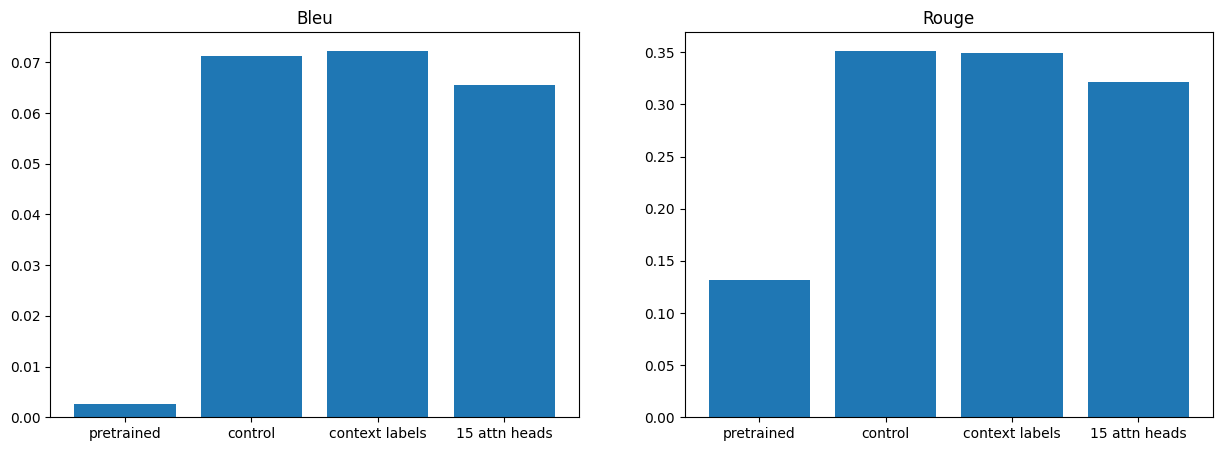

In [89]:
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
bleu_results = [0.0026524365368443847,0.07133228458970757,0.07231884241093674, 0.06544166604677476]
rouge_results = [0.1318835069428388,0.35157515187169935,0.3496136255443621,0.3214492176332781]
labels = ['pretrained','control','context labels','15 attn heads']
ax1.bar(['pretrained','control','context labels','15 attn heads'],bleu_results,label=labels)
ax1.set_title('Bleu')
ax2.bar(['pretrained','control','context labels','15 attn heads'],rouge_results,label=labels)
ax2.set_title('Rouge')
plt.show()

## 6. Conclusion

Overall, the pretrained BART model fares poorly on the task of generating empathetic responses, but the finetuned BART model performs significantly better. There is, however, significant room for improvement, which is non-trivial to realize due to the complex nature of empathy and what an empathetic response might entail in the context of a multi-turn dialogue. On this note, the following are possible directions for future work/research:
- Using alternative metrics that capture more nuances than Bleu and Rouge, e.g. MoverScore and BERTScore.
- Using multiple preceding turns, i.e. not just y(t-1), as input, to capture more nuances in how the each turn of dialogue relates semantically to the overall context of the dialogue as well as its preceding turns.
- Fine-tuning a decoder-only architecture, with the entire preceding part of the dialogue as input.
- Experimenting with a different S2S model, e.g. T5, or a bert-based S2S architecture.
- Tuning other hyperparameters, e.g. layer count and hidden node count. 
- Secure resources to train model on larger sample size
- Leveraging other existing literature for ideas, e.g. applying an additional annotation/tag with a cognitively reasoned inference about the affected person's emotional state, which is an intuition used in Chain-of-Empathy prompting (Lee et al., 2023).

## 7. References

- Lee, Y. K., Lee, I., Shin, M., Bae, S., & Hahn, S. (2023). Chain of Empathy: Enhancing Empathetic Response of Large Language Models Based on Psychotherapy Models. arXiv. 
- Lewis, M., Liu, Y., Goyal, N.,  Ghazvininejad, M., Mohamed, A., Levy, O., Stoyanov, V., & Zettlemoyer, L. (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, 
- Rashkin, H., Smith, E. M., Li, M., & Boureau, Y.-L. (2018, November 1). Towards Empathetic Open-domain Conversation Models: a New Benchmark and Dataset. Translation, and Comprehension. arXiv. 